# 05. Object Detection Fundamentals

Object detection is one of the most important and challenging tasks in computer vision. Unlike image classification, object detection requires both locating objects in images and classifying them. This notebook will introduce you to the fundamentals of object detection using PyTorch.

By the end of this notebook, you'll understand:

- The difference between classification, localization, and detection
- Key object detection architectures (R-CNN, YOLO, SSD)
- How to implement basic object detection from scratch
- Working with bounding boxes and IoU (Intersection over Union)
- Non-Maximum Suppression (NMS)
- Building a simple object detector
- Evaluation metrics for object detection

**Why is object detection important?**

Object detection is fundamental to many real-world applications:

- **Autonomous vehicles**: Detecting cars, pedestrians, traffic signs
- **Security systems**: Identifying people, suspicious objects
- **Medical imaging**: Locating tumors, abnormalities
- **Retail**: Product detection and inventory management
- **Robotics**: Understanding and interacting with the environment


## Object Detection vs Classification

Understanding the key differences between these computer vision tasks is crucial:

### Image Classification

- **Task**: "What is in this image?"
- **Output**: Single class label per image
- **Example**: "This image contains a dog"

### Object Localization

- **Task**: "What is in this image and where is it?"
- **Output**: Class label + bounding box coordinates
- **Example**: "There's a dog at coordinates (x=50, y=30, width=100, height=80)"

### Object Detection

- **Task**: "What objects are in this image and where are they?"
- **Output**: Multiple class labels + multiple bounding boxes
- **Example**: "There's a dog at (50,30,100,80) and a cat at (200,150,80,60)"


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image, ImageDraw
import random
import math
import time
from collections import defaultdict

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using device: {device}")

# Define colors for visualization
COLORS = [
    "#FF6B6B",
    "#4ECDC4",
    "#45B7D1",
    "#96CEB4",
    "#FFEAA7",
    "#DDA0DD",
    "#FF7F50",
    "#87CEEB",
    "#98D8C8",
    "#F7DC6F",
]

Using device: mps


## Understanding Bounding Boxes

Bounding boxes are rectangular regions that enclose objects in images. They're typically represented in different formats.


In [2]:
class BoundingBox:
    """
    A class to handle bounding box operations and conversions
    """

    def __init__(self, x1, y1, x2, y2, format="xyxy"):
        """
        Initialize bounding box
        Args:
            x1, y1, x2, y2: coordinates
            format: 'xyxy' (top-left, bottom-right) or 'xywh' (top-left, width, height) or 'cxcywh' (center-x, center-y, width, height)
        """
        if format == "xyxy":
            self.x1, self.y1, self.x2, self.y2 = x1, y1, x2, y2
        elif format == "xywh":
            self.x1, self.y1 = x1, y1
            self.x2, self.y2 = x1 + x2, y1 + y2
        elif format == "cxcywh":
            cx, cy, w, h = x1, y1, x2, y2
            self.x1 = cx - w / 2
            self.y1 = cy - h / 2
            self.x2 = cx + w / 2
            self.y2 = cy + h / 2
        else:
            raise ValueError("Format must be 'xyxy', 'xywh', or 'cxcywh'")

    def to_xyxy(self):
        """Convert to (x1, y1, x2, y2) format"""
        return [self.x1, self.y1, self.x2, self.y2]

    def to_xywh(self):
        """Convert to (x, y, width, height) format"""
        return [self.x1, self.y1, self.x2 - self.x1, self.y2 - self.y1]

    def to_cxcywh(self):
        """Convert to (center_x, center_y, width, height) format"""
        cx = (self.x1 + self.x2) / 2
        cy = (self.y1 + self.y2) / 2
        w = self.x2 - self.x1
        h = self.y2 - self.y1
        return [cx, cy, w, h]

    def area(self):
        """Calculate area of bounding box"""
        return (self.x2 - self.x1) * (self.y2 - self.y1)

    def __repr__(self):
        return f"BoundingBox(x1={self.x1:.1f}, y1={self.y1:.1f}, x2={self.x2:.1f}, y2={self.y2:.1f})"


def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes
    """
    # Calculate intersection coordinates
    x1_inter = max(box1.x1, box2.x1)
    y1_inter = max(box1.y1, box2.y1)
    x2_inter = min(box1.x2, box2.x2)
    y2_inter = min(box1.y2, box2.y2)

    # Calculate intersection area
    if x2_inter > x1_inter and y2_inter > y1_inter:
        intersection = (x2_inter - x1_inter) * (y2_inter - y1_inter)
    else:
        intersection = 0

    # Calculate union area
    union = box1.area() + box2.area() - intersection

    # Calculate IoU
    if union == 0:
        return 0
    return intersection / union


# Demonstrate bounding box operations
print("Bounding Box Examples:")
box1 = BoundingBox(10, 10, 50, 50, format="xyxy")
box2 = BoundingBox(30, 30, 70, 70, format="xyxy")

print(f"Box 1: {box1}")
print(f"Box 1 (xywh): {box1.to_xywh()}")
print(f"Box 1 (cxcywh): {box1.to_cxcywh()}")
print(f"Box 1 area: {box1.area()}")

print(f"\nBox 2: {box2}")
print(f"IoU between Box 1 and Box 2: {calculate_iou(box1, box2):.3f}")

Bounding Box Examples:
Box 1: BoundingBox(x1=10.0, y1=10.0, x2=50.0, y2=50.0)
Box 1 (xywh): [10, 10, 40, 40]
Box 1 (cxcywh): [30.0, 30.0, 40, 40]
Box 1 area: 1600

Box 2: BoundingBox(x1=30.0, y1=30.0, x2=70.0, y2=70.0)
IoU between Box 1 and Box 2: 0.143


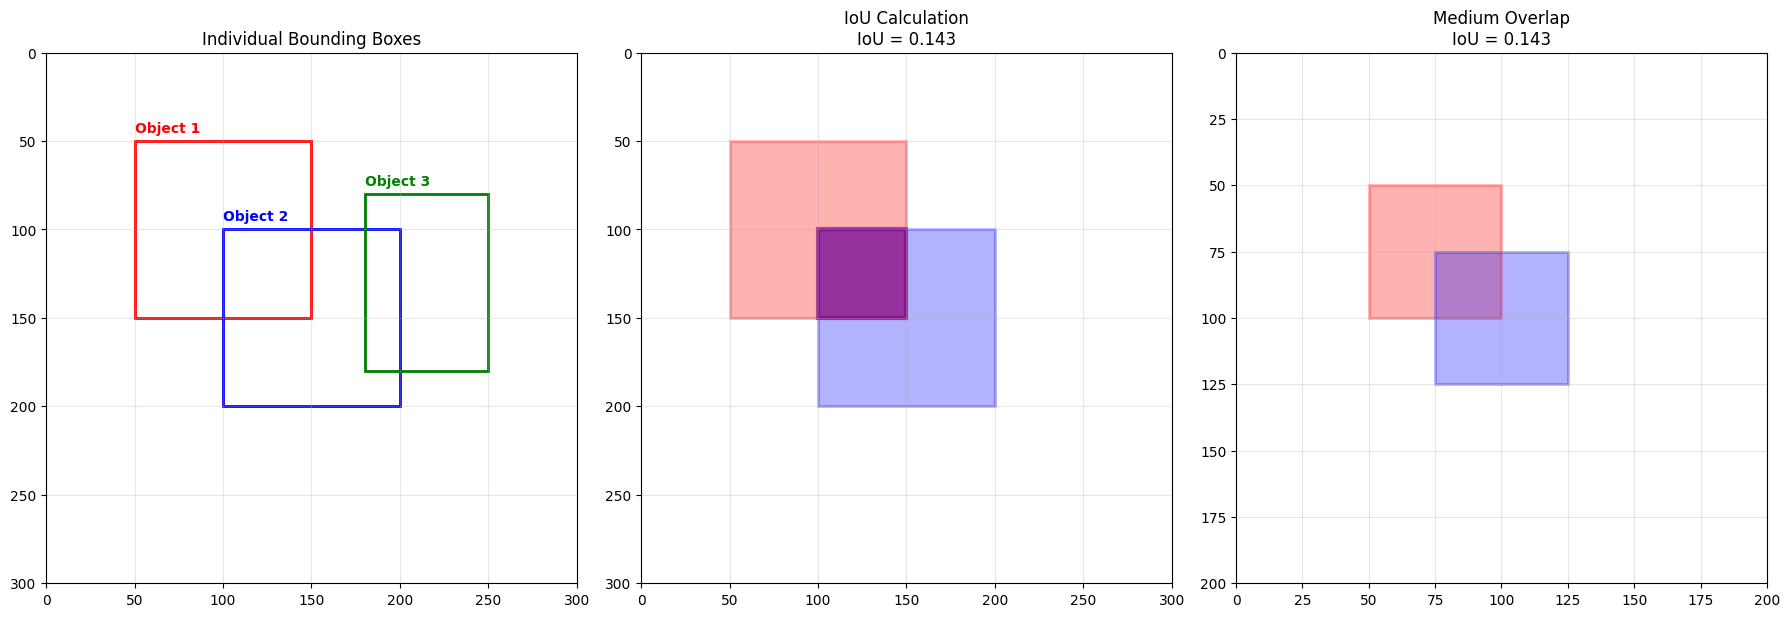

In [3]:
def visualize_bounding_boxes(image_size=(300, 300), boxes_data=None):
    """
    Visualize bounding boxes and IoU calculation
    """
    if boxes_data is None:
        boxes_data = [
            {"box": BoundingBox(50, 50, 150, 150), "label": "Object 1", "color": "red"},
            {
                "box": BoundingBox(100, 100, 200, 200),
                "label": "Object 2",
                "color": "blue",
            },
            {
                "box": BoundingBox(180, 80, 250, 180),
                "label": "Object 3",
                "color": "green",
            },
        ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: Individual boxes
    axes[0].set_xlim(0, image_size[0])
    axes[0].set_ylim(0, image_size[1])
    axes[0].set_aspect("equal")
    axes[0].invert_yaxis()  # Invert y-axis to match image coordinates

    for i, data in enumerate(boxes_data):
        box = data["box"]
        rect = patches.Rectangle(
            (box.x1, box.y1),
            box.x2 - box.x1,
            box.y2 - box.y1,
            linewidth=2,
            edgecolor=data["color"],
            facecolor="none",
        )
        axes[0].add_patch(rect)
        # Add label
        axes[0].text(
            box.x1, box.y1 - 5, data["label"], color=data["color"], fontweight="bold"
        )

    axes[0].set_title("Individual Bounding Boxes")
    axes[0].grid(True, alpha=0.3)

    # Plot 2: IoU calculation between first two boxes
    if len(boxes_data) >= 2:
        box1, box2 = boxes_data[0]["box"], boxes_data[1]["box"]

        axes[1].set_xlim(0, image_size[0])
        axes[1].set_ylim(0, image_size[1])
        axes[1].set_aspect("equal")
        axes[1].invert_yaxis()

        # Draw boxes
        rect1 = patches.Rectangle(
            (box1.x1, box1.y1),
            box1.x2 - box1.x1,
            box1.y2 - box1.y1,
            linewidth=2,
            edgecolor="red",
            facecolor="red",
            alpha=0.3,
        )
        rect2 = patches.Rectangle(
            (box2.x1, box2.y1),
            box2.x2 - box2.x1,
            box2.y2 - box2.y1,
            linewidth=2,
            edgecolor="blue",
            facecolor="blue",
            alpha=0.3,
        )
        axes[1].add_patch(rect1)
        axes[1].add_patch(rect2)

        # Calculate and highlight intersection
        x1_inter = max(box1.x1, box2.x1)
        y1_inter = max(box1.y1, box2.y1)
        x2_inter = min(box1.x2, box2.x2)
        y2_inter = min(box1.y2, box2.y2)

        if x2_inter > x1_inter and y2_inter > y1_inter:
            intersection_rect = patches.Rectangle(
                (x1_inter, y1_inter),
                x2_inter - x1_inter,
                y2_inter - y1_inter,
                linewidth=3,
                edgecolor="purple",
                facecolor="purple",
                alpha=0.6,
            )
            axes[1].add_patch(intersection_rect)

        iou = calculate_iou(box1, box2)
        axes[1].set_title(f"IoU Calculation\nIoU = {iou:.3f}")
        axes[1].grid(True, alpha=0.3)

    # Plot 3: Different IoU scenarios
    scenarios = [
        {
            "boxes": [BoundingBox(50, 50, 100, 100), BoundingBox(75, 75, 125, 125)],
            "title": "Medium Overlap",
        },
        {
            "boxes": [BoundingBox(50, 50, 100, 100), BoundingBox(50, 50, 100, 100)],
            "title": "Perfect Overlap",
        },
        {
            "boxes": [BoundingBox(50, 50, 100, 100), BoundingBox(110, 110, 160, 160)],
            "title": "No Overlap",
        },
    ]

    # Show one scenario
    scenario = scenarios[0]  # Medium overlap
    boxes = scenario["boxes"]

    axes[2].set_xlim(0, 200)
    axes[2].set_ylim(0, 200)
    axes[2].set_aspect("equal")
    axes[2].invert_yaxis()

    colors = ["red", "blue"]
    for i, box in enumerate(boxes):
        rect = patches.Rectangle(
            (box.x1, box.y1),
            box.x2 - box.x1,
            box.y2 - box.y1,
            linewidth=2,
            edgecolor=colors[i],
            facecolor=colors[i],
            alpha=0.3,
        )
        axes[2].add_patch(rect)

    iou = calculate_iou(boxes[0], boxes[1])
    axes[2].set_title(f'{scenario["title"]}\nIoU = {iou:.3f}')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Visualize bounding boxes and IoU
visualize_bounding_boxes()

## Creating Synthetic Object Detection Data

Let's create a synthetic dataset to understand object detection concepts.


Synthetic Object Detection Dataset Examples:


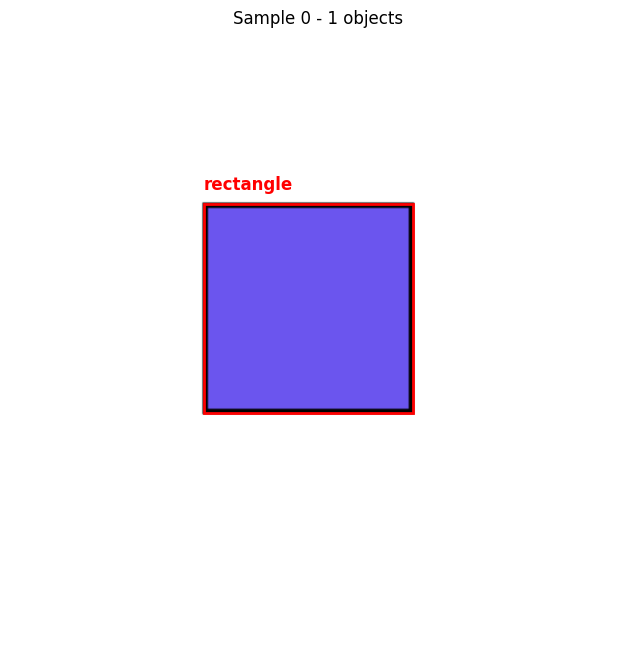

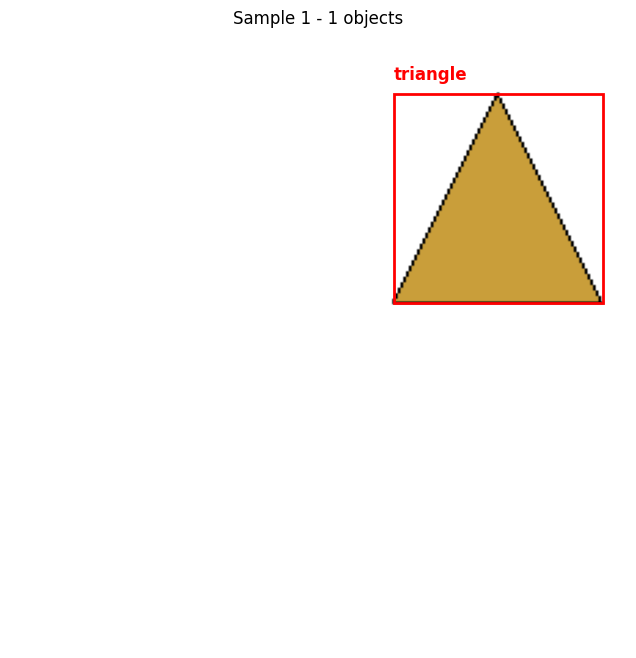

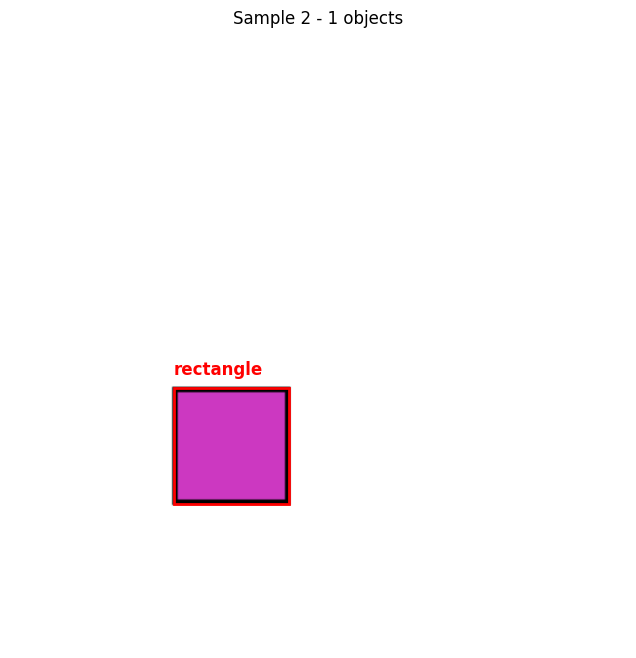

In [4]:
class SyntheticObjectDataset(Dataset):
    """
    Create synthetic object detection data with simple geometric shapes
    """

    def __init__(self, num_samples=1000, image_size=(224, 224), max_objects=3):
        self.num_samples = num_samples
        self.image_size = image_size
        self.max_objects = max_objects
        self.classes = ["rectangle", "circle", "triangle"]
        self.num_classes = len(self.classes)

        # Generate all samples at initialization for consistency
        self.samples = []
        for _ in range(num_samples):
            self.samples.append(self._generate_sample())

    def _generate_sample(self):
        """Generate a single sample with image and annotations"""
        # Create blank image
        image = Image.new("RGB", self.image_size, color="white")
        draw = ImageDraw.Draw(image)

        # Random number of objects (1 to max_objects)
        num_objects = random.randint(1, self.max_objects)

        annotations = []

        for _ in range(num_objects):
            # Random object class
            class_id = random.randint(0, self.num_classes - 1)
            class_name = self.classes[class_id]

            # Random size and position
            size = random.randint(30, 80)
            x = random.randint(size // 2, self.image_size[0] - size // 2)
            y = random.randint(size // 2, self.image_size[1] - size // 2)

            # Random color
            color = (
                random.randint(50, 255),
                random.randint(50, 255),
                random.randint(50, 255),
            )

            # Draw shape and get bounding box
            if class_name == "rectangle":
                x1, y1 = x - size // 2, y - size // 2
                x2, y2 = x + size // 2, y + size // 2
                draw.rectangle([x1, y1, x2, y2], fill=color, outline="black", width=2)
                bbox = [x1, y1, x2, y2]

            elif class_name == "circle":
                x1, y1 = x - size // 2, y - size // 2
                x2, y2 = x + size // 2, y + size // 2
                draw.ellipse([x1, y1, x2, y2], fill=color, outline="black", width=2)
                bbox = [x1, y1, x2, y2]

            elif class_name == "triangle":
                # Draw triangle
                points = [
                    (x, y - size // 2),
                    (x - size // 2, y + size // 2),
                    (x + size // 2, y + size // 2),
                ]
                draw.polygon(points, fill=color, outline="black")
                # Calculate bounding box
                xs = [p[0] for p in points]
                ys = [p[1] for p in points]
                bbox = [min(xs), min(ys), max(xs), max(ys)]

            annotations.append(
                {"class_id": class_id, "class_name": class_name, "bbox": bbox}
            )

        return image, annotations

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.samples[idx]

    def visualize_sample(self, idx):
        """Visualize a sample with annotations"""
        image, annotations = self[idx]

        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.imshow(image)

        for ann in annotations:
            bbox = ann["bbox"]
            class_name = ann["class_name"]

            # Draw bounding box
            rect = patches.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
            ax.add_patch(rect)

            # Add label
            ax.text(
                bbox[0],
                bbox[1] - 5,
                class_name,
                color="red",
                fontweight="bold",
                fontsize=12,
            )

        ax.set_title(f"Sample {idx} - {len(annotations)} objects")
        ax.axis("off")
        plt.show()


# Create synthetic dataset
synthetic_dataset = SyntheticObjectDataset(num_samples=100, max_objects=2)

# Visualize some samples
print("Synthetic Object Detection Dataset Examples:")
for i in range(3):
    synthetic_dataset.visualize_sample(i)

## Object Detection Architectures Overview

Let's understand the major families of object detection algorithms:

### 1. Two-Stage Detectors (R-CNN Family)

- **Concept**: First generate region proposals, then classify them
- **Examples**: R-CNN, Fast R-CNN, Faster R-CNN
- **Pros**: High accuracy
- **Cons**: Slower inference

### 2. One-Stage Detectors

- **Concept**: Direct prediction of bounding boxes and classes
- **Examples**: YOLO, SSD, RetinaNet
- **Pros**: Faster inference
- **Cons**: Traditionally lower accuracy (gap has closed)


## Implementing a Simple YOLO-style Detector

Let's implement a simplified version of YOLO (You Only Look Once) to understand the core concepts.


In [5]:
class SimpleYOLO(nn.Module):
    """
    A simplified YOLO-style object detector
    """

    def __init__(self, num_classes=3, grid_size=7):
        super(SimpleYOLO, self).__init__()
        self.num_classes = num_classes
        self.grid_size = grid_size
        self.num_boxes = 2  # Number of bounding boxes per grid cell

        # Feature extractor (simplified CNN)
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Calculate feature map size after convolutions
        # For 224x224 input: 224/2/2/2/2 = 14x14
        feature_map_size = 224 // 16  # 14

        # Detection head
        # Each grid cell predicts: num_boxes * (4 coords + 1 confidence) + num_classes
        output_size = self.num_boxes * 5 + self.num_classes

        self.detector = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.grid_size),
            nn.Flatten(),
            nn.Linear(512 * self.grid_size * self.grid_size, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, self.grid_size * self.grid_size * output_size),
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Extract features
        features = self.features(x)

        # Detect objects
        detections = self.detector(features)

        # Reshape to (batch, grid, grid, predictions)
        output_size = self.num_boxes * 5 + self.num_classes
        detections = detections.view(
            batch_size, self.grid_size, self.grid_size, output_size
        )

        return detections


# Create and test the model
model = SimpleYOLO(num_classes=3, grid_size=7)
model.eval()

# Test with dummy input
with torch.inference_mode():
    dummy_input = torch.randn(2, 3, 224, 224)
    output = model(dummy_input)
    print(f"Model output shape: {output.shape}")
    print(f"Expected: [batch_size, grid_size, grid_size, predictions]")
    print(f"Predictions per cell: {model.num_boxes * 5 + model.num_classes}")

Model output shape: torch.Size([2, 7, 7, 13])
Expected: [batch_size, grid_size, grid_size, predictions]
Predictions per cell: 13


## Understanding YOLO Grid System

YOLO divides the input image into a grid and each grid cell is responsible for detecting objects whose center falls within that cell.


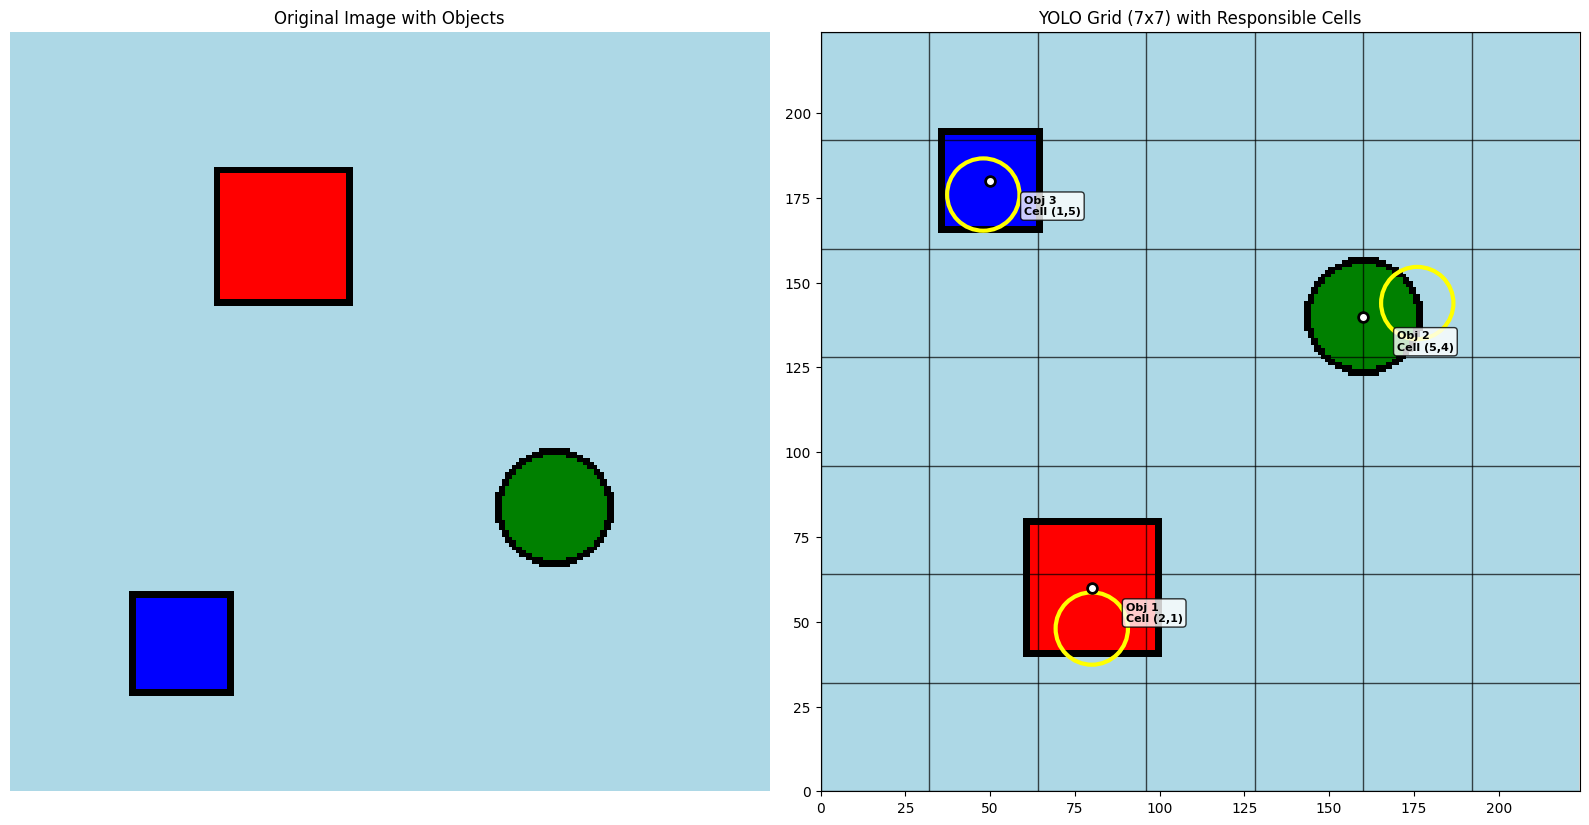

Grid Cell Assignments:
Object 1 (center at (80, 60)) -> Grid cell (2, 1)
Object 2 (center at (160, 140)) -> Grid cell (5, 4)
Object 3 (center at (50, 180)) -> Grid cell (1, 5)


In [6]:
def visualize_yolo_grid(image_size=(224, 224), grid_size=7):
    """
    Visualize how YOLO divides an image into a grid
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Create a sample image with objects
    image = Image.new("RGB", image_size, color="lightblue")
    draw = ImageDraw.Draw(image)

    # Add some objects
    objects = [
        {"center": (80, 60), "size": 40, "color": "red", "shape": "rectangle"},
        {"center": (160, 140), "size": 35, "color": "green", "shape": "circle"},
        {"center": (50, 180), "size": 30, "color": "blue", "shape": "rectangle"},
    ]

    for obj in objects:
        center_x, center_y = obj["center"]
        size = obj["size"]

        if obj["shape"] == "rectangle":
            x1, y1 = center_x - size // 2, center_y - size // 2
            x2, y2 = center_x + size // 2, center_y + size // 2
            draw.rectangle(
                [x1, y1, x2, y2], fill=obj["color"], outline="black", width=2
            )
        elif obj["shape"] == "circle":
            x1, y1 = center_x - size // 2, center_y - size // 2
            x2, y2 = center_x + size // 2, center_y + size // 2
            draw.ellipse([x1, y1, x2, y2], fill=obj["color"], outline="black", width=2)

    # Plot 1: Original image with objects
    axes[0].imshow(image)
    axes[0].set_title("Original Image with Objects")
    axes[0].axis("off")

    # Plot 2: Image with YOLO grid
    axes[1].imshow(image)

    # Draw grid lines
    cell_width = image_size[0] / grid_size
    cell_height = image_size[1] / grid_size

    for i in range(grid_size + 1):
        # Vertical lines
        x = i * cell_width
        axes[1].axvline(x=x, color="black", linewidth=1, alpha=0.7)

        # Horizontal lines
        y = i * cell_height
        axes[1].axhline(y=y, color="black", linewidth=1, alpha=0.7)

    # Mark object centers and responsible grid cells
    for i, obj in enumerate(objects):
        center_x, center_y = obj["center"]

        # Mark center
        axes[1].plot(center_x, center_y, "ko", markersize=8)
        axes[1].plot(center_x, center_y, "wo", markersize=4)

        # Find responsible grid cell
        grid_x = int(center_x // cell_width)
        grid_y = int(center_y // cell_height)

        # Highlight responsible cell
        cell_center_x = (grid_x + 0.5) * cell_width
        cell_center_y = (grid_y + 0.5) * cell_height

        # Draw a circle around the responsible cell
        circle = patches.Circle(
            (cell_center_x, cell_center_y),
            radius=min(cell_width, cell_height) / 3,
            linewidth=3,
            edgecolor="yellow",
            facecolor="none",
        )
        axes[1].add_patch(circle)

        # Add text
        axes[1].text(
            center_x + 10,
            center_y - 10,
            f"Obj {i+1}\nCell ({grid_x},{grid_y})",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
            fontsize=8,
            fontweight="bold",
        )

    axes[1].set_title(f"YOLO Grid ({grid_size}x{grid_size}) with Responsible Cells")
    axes[1].set_xlim(0, image_size[0])
    axes[1].set_ylim(0, image_size[1])

    plt.tight_layout()
    plt.show()

    # Print grid assignment information
    print("Grid Cell Assignments:")
    cell_width = image_size[0] / grid_size
    cell_height = image_size[1] / grid_size

    for i, obj in enumerate(objects):
        center_x, center_y = obj["center"]
        grid_x = int(center_x // cell_width)
        grid_y = int(center_y // cell_height)
        print(
            f"Object {i+1} (center at {obj['center']}) -> Grid cell ({grid_x}, {grid_y})"
        )


visualize_yolo_grid()

## Non-Maximum Suppression (NMS)

NMS is crucial for removing duplicate detections. Let's implement and visualize it.


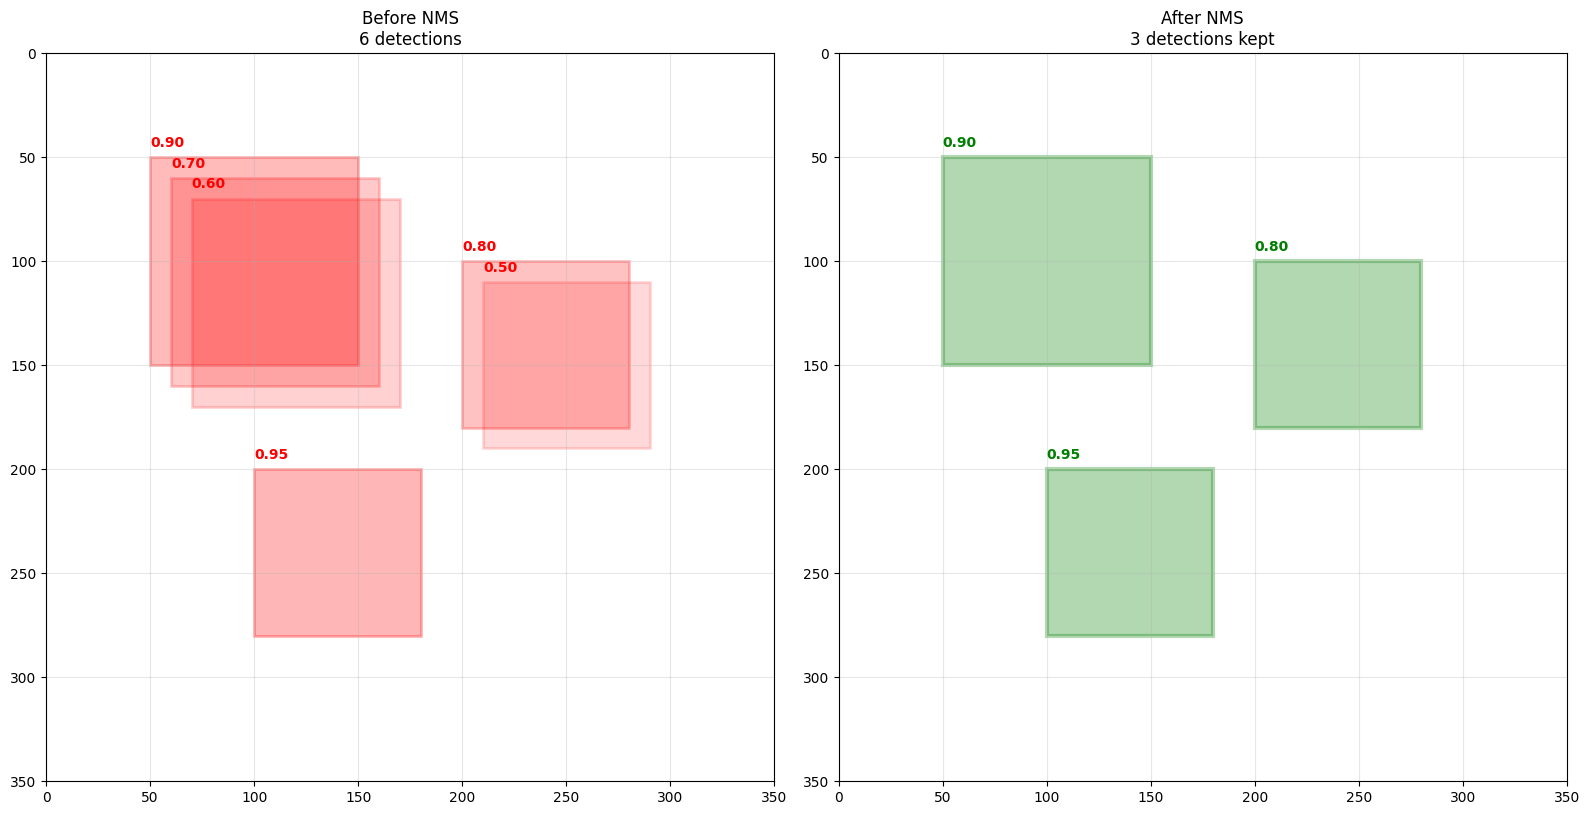

NMS Results:
Original detections: 6
After NMS: 3
Kept detection indices: [5, 0, 3]
Kept scores: [0.95, 0.9, 0.8]


In [7]:
def non_maximum_suppression(boxes, scores, iou_threshold=0.5, score_threshold=0.1):
    """
    Apply Non-Maximum Suppression to remove duplicate detections

    Args:
        boxes: List of BoundingBox objects
        scores: List of confidence scores
        iou_threshold: IoU threshold for suppression
        score_threshold: Minimum score threshold

    Returns:
        List of indices of boxes to keep
    """
    # Filter by score threshold
    valid_indices = [i for i, score in enumerate(scores) if score >= score_threshold]

    if not valid_indices:
        return []

    # Sort by score (descending)
    valid_indices.sort(key=lambda i: scores[i], reverse=True)

    keep = []

    while valid_indices:
        # Take the box with highest score
        current_idx = valid_indices.pop(0)
        keep.append(current_idx)
        current_box = boxes[current_idx]

        # Remove boxes with high IoU with current box
        remaining_indices = []
        for idx in valid_indices:
            if calculate_iou(current_box, boxes[idx]) <= iou_threshold:
                remaining_indices.append(idx)

        valid_indices = remaining_indices

    return keep


def visualize_nms():
    """Demonstrate Non-Maximum Suppression"""

    # Create overlapping detections
    detections = [
        {"box": BoundingBox(50, 50, 150, 150), "score": 0.9, "class": "object"},
        {"box": BoundingBox(60, 60, 160, 160), "score": 0.7, "class": "object"},
        {"box": BoundingBox(70, 70, 170, 170), "score": 0.6, "class": "object"},
        {"box": BoundingBox(200, 100, 280, 180), "score": 0.8, "class": "object"},
        {"box": BoundingBox(210, 110, 290, 190), "score": 0.5, "class": "object"},
        {"box": BoundingBox(100, 200, 180, 280), "score": 0.95, "class": "object"},
    ]

    boxes = [d["box"] for d in detections]
    scores = [d["score"] for d in detections]

    # Apply NMS
    keep_indices = non_maximum_suppression(
        boxes, scores, iou_threshold=0.3, score_threshold=0.4
    )

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot 1: Before NMS
    axes[0].set_xlim(0, 350)
    axes[0].set_ylim(0, 350)
    axes[0].set_aspect("equal")
    axes[0].invert_yaxis()

    for i, detection in enumerate(detections):
        box = detection["box"]
        score = detection["score"]

        # Color based on score
        alpha = score
        color = "red" if score >= 0.4 else "gray"

        rect = patches.Rectangle(
            (box.x1, box.y1),
            box.x2 - box.x1,
            box.y2 - box.y1,
            linewidth=2,
            edgecolor=color,
            facecolor=color,
            alpha=alpha * 0.3,
        )
        axes[0].add_patch(rect)

        # Add score label
        axes[0].text(
            box.x1,
            box.y1 - 5,
            f"{score:.2f}",
            color=color,
            fontweight="bold",
            fontsize=10,
        )

    axes[0].set_title(f"Before NMS\n{len(detections)} detections")
    axes[0].grid(True, alpha=0.3)

    # Plot 2: After NMS
    axes[1].set_xlim(0, 350)
    axes[1].set_ylim(0, 350)
    axes[1].set_aspect("equal")
    axes[1].invert_yaxis()

    for i in keep_indices:
        detection = detections[i]
        box = detection["box"]
        score = detection["score"]

        rect = patches.Rectangle(
            (box.x1, box.y1),
            box.x2 - box.x1,
            box.y2 - box.y1,
            linewidth=3,
            edgecolor="green",
            facecolor="green",
            alpha=0.3,
        )
        axes[1].add_patch(rect)

        # Add score label
        axes[1].text(
            box.x1,
            box.y1 - 5,
            f"{score:.2f}",
            color="green",
            fontweight="bold",
            fontsize=10,
        )

    axes[1].set_title(f"After NMS\n{len(keep_indices)} detections kept")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("NMS Results:")
    print(f"Original detections: {len(detections)}")
    print(f"After NMS: {len(keep_indices)}")
    print(f"Kept detection indices: {keep_indices}")
    print(f"Kept scores: {[scores[i] for i in keep_indices]}")


visualize_nms()

## Object Detection Loss Functions

Object detection requires multiple loss components: classification loss, localization loss, and confidence loss.


In [8]:
class YOLOLoss(nn.Module):
    """
    Simplified YOLO loss function
    """

    def __init__(
        self,
        num_classes=3,
        num_boxes=2,
        grid_size=7,
        lambda_coord=5.0,
        lambda_noobj=0.5,
    ):
        super(YOLOLoss, self).__init__()
        self.num_classes = num_classes
        self.num_boxes = num_boxes
        self.grid_size = grid_size
        self.lambda_coord = lambda_coord  # Weight for coordinate loss
        self.lambda_noobj = lambda_noobj  # Weight for no-object confidence loss

        self.mse_loss = nn.MSELoss(reduction="sum")
        self.bce_loss = nn.BCELoss(reduction="sum")

    def forward(self, predictions, targets):
        """
        Calculate YOLO loss

        Args:
            predictions: Model output [batch, grid, grid, predictions]
            targets: Ground truth [batch, grid, grid, predictions]
        """
        batch_size = predictions.size(0)

        # Split predictions into components
        # Each cell predicts: [box1_coords(4), box1_conf(1), box2_coords(4), box2_conf(1), classes(num_classes)]

        coord_loss = 0
        conf_loss = 0
        class_loss = 0

        for i in range(batch_size):
            for row in range(self.grid_size):
                for col in range(self.grid_size):
                    # Get predictions and targets for this cell
                    pred_cell = predictions[i, row, col]
                    target_cell = targets[i, row, col]

                    # Check if this cell contains an object
                    has_object = target_cell[4] > 0  # First box confidence in target

                    if has_object:
                        # Coordinate loss (only for responsible box)
                        pred_coords = pred_cell[:4]  # First box coordinates
                        target_coords = target_cell[:4]

                        coord_loss += self.lambda_coord * self.mse_loss(
                            pred_coords, target_coords
                        )

                        # Confidence loss for object cell
                        pred_conf = pred_cell[4]  # First box confidence
                        target_conf = target_cell[4]
                        conf_loss += self.mse_loss(
                            pred_conf.unsqueeze(0), target_conf.unsqueeze(0)
                        )

                        # Class loss
                        pred_classes = pred_cell[-self.num_classes :]
                        target_classes = target_cell[-self.num_classes :]
                        class_loss += self.mse_loss(pred_classes, target_classes)

                    else:
                        # No object confidence loss
                        for box_idx in range(self.num_boxes):
                            conf_idx = 4 + box_idx * 5  # Confidence index for each box
                            pred_conf = pred_cell[conf_idx]
                            conf_loss += self.lambda_noobj * self.mse_loss(
                                pred_conf.unsqueeze(0), torch.zeros(1)
                            )

        total_loss = coord_loss + conf_loss + class_loss

        return {
            "total_loss": total_loss,
            "coord_loss": coord_loss,
            "conf_loss": conf_loss,
            "class_loss": class_loss,
        }


# Demonstrate loss calculation
def demonstrate_yolo_loss():
    """Demonstrate YOLO loss calculation"""

    # Create dummy predictions and targets
    batch_size, grid_size = 2, 7
    num_classes, num_boxes = 3, 2
    predictions_size = num_boxes * 5 + num_classes

    # Random predictions
    predictions = torch.randn(batch_size, grid_size, grid_size, predictions_size)

    # Create targets (mostly zeros, with a few objects)
    targets = torch.zeros(batch_size, grid_size, grid_size, predictions_size)

    # Add a few objects to targets
    # Object 1: Rectangle at grid cell (2, 3)
    targets[0, 2, 3, :4] = torch.tensor([0.5, 0.5, 0.3, 0.3])  # Normalized coordinates
    targets[0, 2, 3, 4] = 1.0  # Confidence
    targets[0, 2, 3, -3:] = torch.tensor([1.0, 0.0, 0.0])  # Class: rectangle

    # Object 2: Circle at grid cell (4, 1)
    targets[1, 4, 1, :4] = torch.tensor([0.7, 0.2, 0.25, 0.25])
    targets[1, 4, 1, 4] = 1.0
    targets[1, 4, 1, -3:] = torch.tensor([0.0, 1.0, 0.0])  # Class: circle

    # Calculate loss
    criterion = YOLOLoss(
        num_classes=num_classes, num_boxes=num_boxes, grid_size=grid_size
    )
    loss_dict = criterion(predictions, targets)

    print("YOLO Loss Components:")
    for loss_name, loss_value in loss_dict.items():
        print(f"{loss_name}: {loss_value.item():.4f}")

    return loss_dict


loss_example = demonstrate_yolo_loss()

YOLO Loss Components:
total_loss: 176.4552
coord_loss: 58.2964
conf_loss: 112.1551
class_loss: 6.0038


## Evaluation Metrics for Object Detection

Object detection uses specific metrics like mAP (mean Average Precision) to evaluate performance.


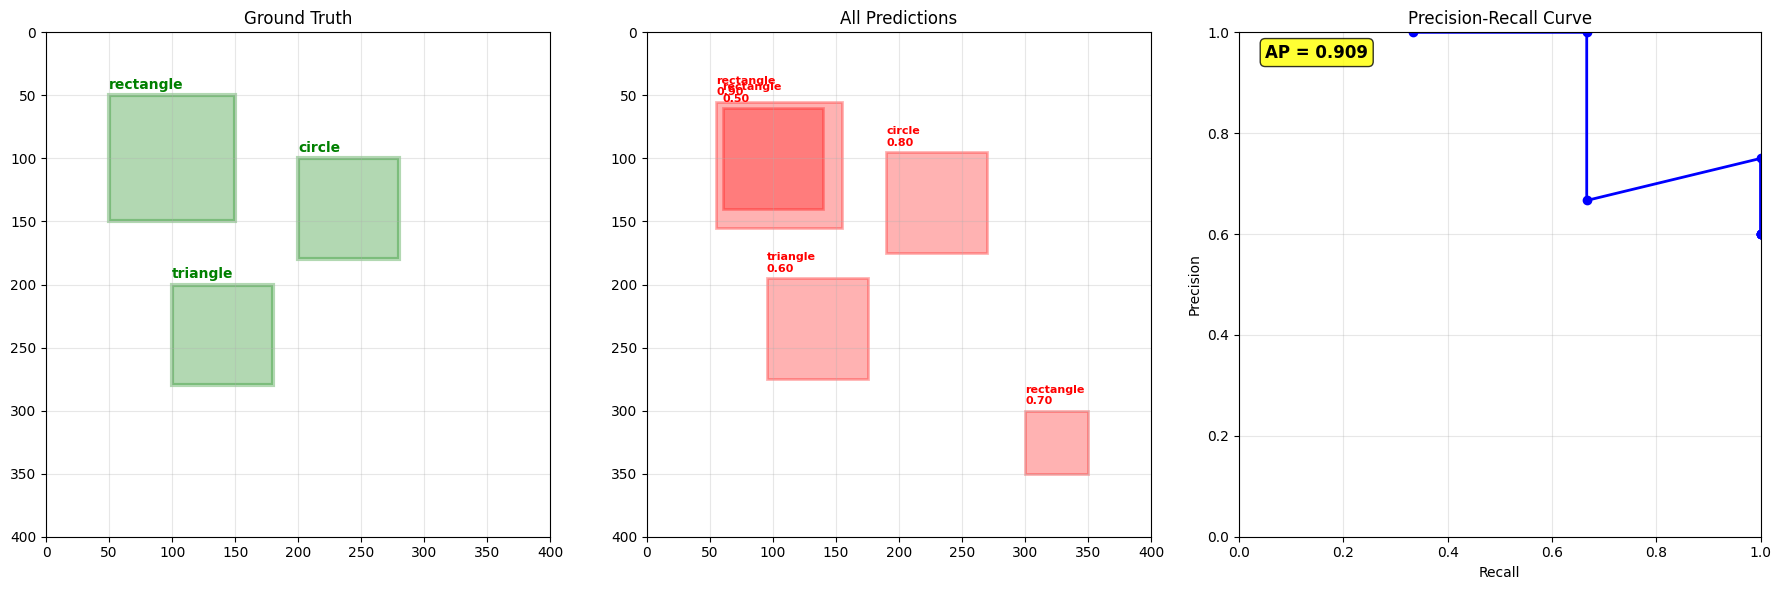

Detection Evaluation Results:
Conf Thresh  Precision  Recall   TP   FP   FN  
0.9          1.000      0.333    1    0    2   
0.8          1.000      0.667    2    0    1   
0.7          0.667      0.667    2    1    1   
0.6          0.750      1.000    3    1    0   
0.5          0.600      1.000    3    2    0   
0.4          0.600      1.000    3    2    0   
0.3          0.600      1.000    3    2    0   
0.2          0.600      1.000    3    2    0   
0.1          0.600      1.000    3    2    0   
Average Precision (AP): 0.909


In [9]:
def calculate_precision_recall(predictions, ground_truths, iou_threshold=0.5):
    """
    Calculate precision and recall for object detection

    Args:
        predictions: List of dicts with 'box', 'score', 'class'
        ground_truths: List of dicts with 'box', 'class'
        iou_threshold: IoU threshold for positive match

    Returns:
        precision, recall, true_positives, false_positives, false_negatives
    """
    # Sort predictions by confidence score (descending)
    predictions = sorted(predictions, key=lambda x: x["score"], reverse=True)

    true_positives = 0
    false_positives = 0
    false_negatives = len(ground_truths)

    matched_gt = set()  # Track which ground truth boxes have been matched

    for pred in predictions:
        best_iou = 0
        best_gt_idx = -1

        # Find best matching ground truth
        for gt_idx, gt in enumerate(ground_truths):
            if gt_idx in matched_gt:
                continue

            if pred["class"] == gt["class"]:
                iou = calculate_iou(pred["box"], gt["box"])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx

        # Check if it's a true positive
        if best_iou >= iou_threshold and best_gt_idx != -1:
            true_positives += 1
            false_negatives -= 1
            matched_gt.add(best_gt_idx)
        else:
            false_positives += 1

    # Calculate precision and recall
    precision = (
        true_positives / (true_positives + false_positives)
        if (true_positives + false_positives) > 0
        else 0
    )
    recall = (
        true_positives / (true_positives + false_negatives)
        if (true_positives + false_negatives) > 0
        else 0
    )

    return precision, recall, true_positives, false_positives, false_negatives


def calculate_average_precision(precisions, recalls):
    """Calculate Average Precision using the 11-point interpolation method"""
    # Add boundary points
    recalls = [0] + recalls + [1]
    precisions = [0] + precisions + [0]

    # Compute interpolated precision
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i + 1])

    # Calculate AP using 11-point interpolation
    ap = 0
    recall_thresholds = [i / 10.0 for i in range(11)]

    for r_thresh in recall_thresholds:
        # Find precision at this recall level
        for i, r in enumerate(recalls):
            if r >= r_thresh:
                ap += precisions[i] / 11
                break

    return ap


def demonstrate_detection_metrics():
    """Demonstrate object detection evaluation metrics"""

    # Create example predictions and ground truths
    ground_truths = [
        {"box": BoundingBox(50, 50, 150, 150), "class": "rectangle"},
        {"box": BoundingBox(200, 100, 280, 180), "class": "circle"},
        {"box": BoundingBox(100, 200, 180, 280), "class": "triangle"},
    ]

    predictions = [
        {
            "box": BoundingBox(55, 55, 155, 155),
            "score": 0.9,
            "class": "rectangle",
        },  # Good match
        {
            "box": BoundingBox(190, 95, 270, 175),
            "score": 0.8,
            "class": "circle",
        },  # Good match
        {
            "box": BoundingBox(300, 300, 350, 350),
            "score": 0.7,
            "class": "rectangle",
        },  # False positive
        {
            "box": BoundingBox(95, 195, 175, 275),
            "score": 0.6,
            "class": "triangle",
        },  # Good match
        {
            "box": BoundingBox(60, 60, 140, 140),
            "score": 0.5,
            "class": "rectangle",
        },  # Duplicate
    ]

    # Calculate metrics at different confidence thresholds
    confidence_thresholds = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    results = []

    for conf_thresh in confidence_thresholds:
        # Filter predictions by confidence
        filtered_preds = [p for p in predictions if p["score"] >= conf_thresh]

        # Calculate metrics
        precision, recall, tp, fp, fn = calculate_precision_recall(
            filtered_preds, ground_truths, iou_threshold=0.5
        )

        results.append(
            {
                "confidence_threshold": conf_thresh,
                "precision": precision,
                "recall": recall,
                "tp": tp,
                "fp": fp,
                "fn": fn,
            }
        )

    # Visualize predictions and ground truths
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: Ground truth
    axes[0].set_xlim(0, 400)
    axes[0].set_ylim(0, 400)
    axes[0].set_aspect("equal")
    axes[0].invert_yaxis()

    for gt in ground_truths:
        box = gt["box"]
        rect = patches.Rectangle(
            (box.x1, box.y1),
            box.x2 - box.x1,
            box.y2 - box.y1,
            linewidth=3,
            edgecolor="green",
            facecolor="green",
            alpha=0.3,
        )
        axes[0].add_patch(rect)
        axes[0].text(box.x1, box.y1 - 5, gt["class"], color="green", fontweight="bold")

    axes[0].set_title("Ground Truth")
    axes[0].grid(True, alpha=0.3)

    # Plot 2: All predictions
    axes[1].set_xlim(0, 400)
    axes[1].set_ylim(0, 400)
    axes[1].set_aspect("equal")
    axes[1].invert_yaxis()

    for pred in predictions:
        box = pred["box"]
        rect = patches.Rectangle(
            (box.x1, box.y1),
            box.x2 - box.x1,
            box.y2 - box.y1,
            linewidth=2,
            edgecolor="red",
            facecolor="red",
            alpha=0.3,
        )
        axes[1].add_patch(rect)
        axes[1].text(
            box.x1,
            box.y1 - 5,
            f"{pred['class']}\n{pred['score']:.2f}",
            color="red",
            fontweight="bold",
            fontsize=8,
        )

    axes[1].set_title("All Predictions")
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Precision-Recall curve
    precisions = [r["precision"] for r in results]
    recalls = [r["recall"] for r in results]

    axes[2].plot(recalls, precisions, "b-o", linewidth=2, markersize=6)
    axes[2].set_xlabel("Recall")
    axes[2].set_ylabel("Precision")
    axes[2].set_title("Precision-Recall Curve")
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlim(0, 1)
    axes[2].set_ylim(0, 1)

    # Calculate and display AP
    ap = calculate_average_precision(precisions, recalls)
    axes[2].text(
        0.05,
        0.95,
        f"AP = {ap:.3f}",
        transform=axes[2].transAxes,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8),
        fontsize=12,
        fontweight="bold",
    )

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("Detection Evaluation Results:")
    print("=" * 70)
    print(
        f"{'Conf Thresh':<12} {'Precision':<10} {'Recall':<8} {'TP':<4} {'FP':<4} {'FN':<4}"
    )
    print("=" * 70)

    for result in results:
        print(
            f"{result['confidence_threshold']:<12.1f} "
            f"{result['precision']:<10.3f} "
            f"{result['recall']:<8.3f} "
            f"{result['tp']:<4d} "
            f"{result['fp']:<4d} "
            f"{result['fn']:<4d}"
        )

    print("=" * 70)
    print(f"Average Precision (AP): {ap:.3f}")

    return results, ap


# Run the demonstration
metrics_results, ap_score = demonstrate_detection_metrics()

## Working with Real Object Detection Models

Let's demonstrate how to use pre-trained object detection models from torchvision.


Pre-trained Object Detection Model Demo:
Note: This uses a pre-trained Faster R-CNN model trained on COCO dataset

Model Architecture (Faster R-CNN):
- Backbone: ResNet-50 with Feature Pyramid Network (FPN)
- Region Proposal Network (RPN): Generates object proposals
- ROI Head: Classifies proposals and refines bounding boxes
- Trained on COCO dataset (80 object classes)


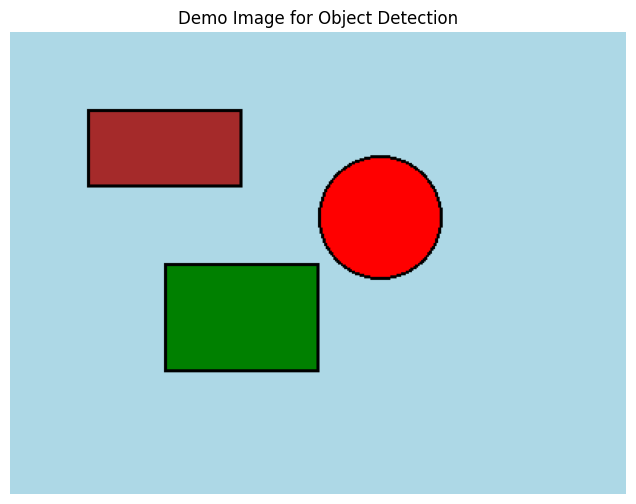

In [10]:
# Note: This requires torchvision and may need to download pre-trained weights
try:
    from torchvision.models import detection
    from torchvision.transforms import functional as F

    def load_pretrained_detector():
        """Load a pre-trained object detection model"""
        # Load pre-trained Faster R-CNN model
        model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
        model.eval()
        return model

    def detect_objects_pretrained(image, model, confidence_threshold=0.5):
        """
        Detect objects using a pre-trained model
        """
        # Prepare image
        if isinstance(image, Image.Image):
            image_tensor = F.to_tensor(image).unsqueeze(0)
        else:
            image_tensor = image

        # Run inference
        with torch.inference_mode():
            predictions = model(image_tensor)

        # Process predictions
        boxes = predictions[0]["boxes"].cpu().numpy()
        scores = predictions[0]["scores"].cpu().numpy()
        labels = predictions[0]["labels"].cpu().numpy()

        # Filter by confidence
        keep = scores >= confidence_threshold
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]

        return boxes, scores, labels

    # COCO class names (for pre-trained model)
    COCO_CLASSES = [
        "__background__",
        "person",
        "bicycle",
        "car",
        "motorcycle",
        "airplane",
        "bus",
        "train",
        "truck",
        "boat",
        "traffic light",
        "fire hydrant",
        "N/A",
        "stop sign",
        "parking meter",
        "bench",
        "bird",
        "cat",
        "dog",
        "horse",
        "sheep",
        "cow",
        "elephant",
        "bear",
        "zebra",
        "giraffe",
        "N/A",
        "backpack",
        "umbrella",
        "N/A",
        "N/A",
        "handbag",
        "tie",
        "suitcase",
        "frisbee",
        "skis",
        "snowboard",
        "sports ball",
        "kite",
        "baseball bat",
        "baseball glove",
        "skateboard",
        "surfboard",
        "tennis racket",
        "bottle",
        "N/A",
        "wine glass",
        "cup",
        "fork",
        "knife",
        "spoon",
        "bowl",
        "banana",
        "apple",
        "sandwich",
        "orange",
        "broccoli",
        "carrot",
        "hot dog",
        "pizza",
        "donut",
        "cake",
        "chair",
        "couch",
        "potted plant",
        "bed",
        "N/A",
        "dining table",
        "N/A",
        "N/A",
        "toilet",
        "N/A",
        "tv",
        "laptop",
        "mouse",
        "remote",
        "keyboard",
        "cell phone",
        "microwave",
        "oven",
        "toaster",
        "sink",
        "refrigerator",
        "N/A",
        "book",
        "clock",
        "vase",
        "scissors",
        "teddy bear",
        "hair drier",
        "toothbrush",
    ]

    def create_demo_image_with_common_objects():
        """Create a demo image with common objects that COCO model can detect"""
        # Create an image with simple shapes that might resemble common objects
        image = Image.new("RGB", (400, 300), color="lightblue")
        draw = ImageDraw.Draw(image)

        # Draw some simple shapes
        # Rectangle (might be detected as various objects)
        draw.rectangle([50, 50, 150, 100], fill="brown", outline="black", width=2)

        # Circle (might be detected as a ball or similar)
        draw.ellipse([200, 80, 280, 160], fill="red", outline="black", width=2)

        # Another rectangle
        draw.rectangle([100, 150, 200, 220], fill="green", outline="black", width=2)

        return image

    print("Pre-trained Object Detection Model Demo:")
    print("Note: This uses a pre-trained Faster R-CNN model trained on COCO dataset")

    # Create demo image
    demo_image = create_demo_image_with_common_objects()

    # Note: Loading pre-trained models requires internet connection and may take time
    # For demonstration purposes, we'll show the structure without actually loading
    print("\nModel Architecture (Faster R-CNN):")
    print("- Backbone: ResNet-50 with Feature Pyramid Network (FPN)")
    print("- Region Proposal Network (RPN): Generates object proposals")
    print("- ROI Head: Classifies proposals and refines bounding boxes")
    print("- Trained on COCO dataset (80 object classes)")

    plt.figure(figsize=(8, 6))
    plt.imshow(demo_image)
    plt.title("Demo Image for Object Detection")
    plt.axis("off")
    plt.show()

except ImportError:
    print("Note: Pre-trained models demo requires torchvision with internet connection")
    print("The concepts shown above apply to any object detection model")

## Training Tips and Best Practices

### 1. Data Preparation

- **Annotations**: Ensure accurate bounding box annotations
- **Data Augmentation**: Use appropriate augmentations (horizontal flip, rotation, color jittering)
- **Class Balance**: Handle class imbalance with weighted sampling or focal loss

### 2. Model Selection

- **Two-stage vs One-stage**: Choose based on accuracy vs speed requirements
- **Backbone**: Stronger backbones (ResNet, EfficientNet) generally improve performance
- **Input Resolution**: Higher resolution improves small object detection

### 3. Training Strategy

- **Learning Rate**: Use learning rate scheduling (step, cosine, etc.)
- **Batch Size**: Larger batch sizes often improve stability
- **Loss Weighting**: Balance classification, localization, and confidence losses

### 4. Evaluation and Debugging

- **Visualization**: Always visualize predictions during training
- **mAP Monitoring**: Track mAP at different IoU thresholds
- **Anchor Analysis**: For anchor-based methods, analyze anchor matching


In [ ]:
def create_training_pipeline_example():
    """Example of a complete object detection training pipeline structure"""

    print("Object Detection Training Pipeline:")
    print("=" * 50)

    pipeline_steps = [
        "1. Data Preparation",
        "   - Load and parse annotations (COCO, YOLO, Pascal VOC format)",
        "   - Create custom Dataset class",
        "   - Apply appropriate data augmentations",
        "   - Set up train/validation/test splits",
        "",
        "2. Model Setup",
        "   - Choose architecture (YOLO, Faster R-CNN, SSD, etc.)",
        "   - Initialize backbone (often with ImageNet pre-training)",
        "   - Configure detection head for your number of classes",
        "",
        "3. Loss Function",
        "   - Classification loss (CrossEntropy, Focal Loss)",
        "   - Localization loss (Smooth L1, IoU Loss, GIoU Loss)",
        "   - Confidence/Objectness loss",
        "",
        "4. Training Loop",
        "   - Forward pass: model predictions",
        "   - Loss calculation: compare with ground truth",
        "   - Backward pass: gradient computation",
        "   - Optimization step: parameter update",
        "   - Metrics logging: mAP, loss components",
        "",
        "5. Evaluation",
        "   - Non-Maximum Suppression on predictions",
        "   - Calculate mAP at different IoU thresholds",
        "   - Visualize predictions vs ground truth",
        "   - Error analysis: missed objects, false positives",
        "",
        "6. Inference Optimization",
        "   - Model quantization for deployment",
        "   - TensorRT or ONNX conversion",
        "   - Batch processing for efficiency",
    ]

    for step in pipeline_steps:
        print(step)

    # Show a simplified training loop structure
    print("\n" + "=" * 50)
    print("Simplified Training Loop Structure:")
    print("=" * 50)

    training_code = """
def train_detector(model, train_loader, val_loader, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = YOLOLoss()  # Or appropriate loss function
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            # Forward pass
            predictions = model(images)
            
            # Calculate loss
            loss_dict = criterion(predictions, targets)
            total_loss = loss_dict['total_loss']
            
            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            train_loss += total_loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {total_loss:.4f}')
        
        # Validation
        model.eval()
        with torch.inference_mode():
            val_map = evaluate_detector(model, val_loader)
            print(f'Epoch {epoch}, Train Loss: {train_loss/len(train_loader):.4f}, Val mAP: {val_map:.4f}')
    """

    print(training_code)


create_training_pipeline_example()

## Summary

In this notebook, we've covered the fundamentals of object detection:

### Key Concepts Learned:

1. **Object Detection vs Classification**: Understanding the differences and challenges
2. **Bounding Boxes**: Representation, conversion, and IoU calculation
3. **Detection Architectures**: Two-stage vs one-stage approaches
4. **YOLO Concepts**: Grid-based detection and loss functions
5. **Non-Maximum Suppression**: Removing duplicate detections
6. **Evaluation Metrics**: Precision, recall, and Average Precision (AP)
7. **Best Practices**: Training tips and pipeline structure

### Real-World Applications:

- **Autonomous Vehicles**: Detecting pedestrians, vehicles, traffic signs
- **Security Systems**: People detection, suspicious object identification
- **Medical Imaging**: Tumor detection, anatomical structure localization
- **Retail**: Product recognition, inventory management
- **Manufacturing**: Defect detection, quality control

### Next Steps:

1. **Implement a complete YOLO detector** from scratch
2. **Experiment with different architectures** (Faster R-CNN, SSD, RetinaNet)
3. **Work with real datasets** (COCO, Pascal VOC, Open Images)
4. **Optimize for deployment** (quantization, pruning, distillation)
5. **Explore advanced topics** (3D object detection, video object tracking)

### Popular Object Detection Frameworks:

- **Detectron2** (Facebook): Comprehensive detection framework
- **YOLOv5/YOLOv8** (Ultralytics): Fast and easy-to-use YOLO implementations
- **MMDetection** (OpenMMLab): Research-oriented detection toolbox
- **TorchVision**: Built-in PyTorch detection models

Remember: **Object detection is a complex task that requires careful attention to data quality, model architecture, and evaluation metrics. Start simple and gradually increase complexity!**
